In [1]:
'''
!pip install category_encoders
!pip install -U pandas-profiling
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.21.2
#!pip install -U scikit-learn
!pip install xgboost
!pip install eli5
!pip install shap'''

'\n!pip install category_encoders\n!pip install -U pandas-profiling\n!pip uninstall scikit-learn -y\n!pip install scikit-learn==0.21.2\n#!pip install -U scikit-learn\n!pip install xgboost\n!pip install eli5\n!pip install shap'

# Hotel booking 


# Data setting

## Data Read

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/hotel_bookings.csv')
print(df.shape)
df.info()

(119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  mea

## EDA

In [4]:
df = df.drop_duplicates()

df = df.drop('company',axis=1)
df = df.dropna()

print(df['is_canceled'].value_counts(normalize=True))

df['arrival_date'] = df['arrival_date_year'].astype(str) +'-' +df['arrival_date_month'] + '-' +df['arrival_date_day_of_month'].astype(str)
df = df.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','arrival_date_week_number','agent','country'],axis=1)
df = df.reset_index(drop=True)

0    0.700802
1    0.299198
Name: is_canceled, dtype: float64


In [5]:
df.shape

(75074, 26)

In [6]:
import pandas_profiling

profile = df.profile_report()
#profile

## Feature Engineering

In [7]:
# Engineering

def engineering(df):
  df.loc[:,'reservation_status_date'] = pd.to_datetime(df.loc[:,'reservation_status_date'])
  df.loc[:, 'arrival_date'] = pd.to_datetime(df.loc[:,'arrival_date'])
  df.loc[:, 'reservation_status_date'] = pd.to_datetime(df.loc[:,'reservation_status_date'])
  df.loc[:, 'arrival_date'] = pd.to_datetime(df.loc[:, 'arrival_date'])
  df.loc[:, 'stay_in_all_days'] = df.loc[:, 'stays_in_week_nights'] + df.loc[:, 'stays_in_weekend_nights']
  df.loc[:, 'fare_per_day'] = df.loc[:,'adr'] / df.loc[:, 'stay_in_all_days'].astype(float)
  df = df.drop(['reservation_status_date',	'arrival_date','reservation_status'],axis=1)
  df = df.dropna()
  df = df.reset_index(drop=True)
  return df

df = engineering(df)

# Model selection

In [8]:
from scipy.stats import randint, uniform
import numpy as np

# data split
from sklearn.model_selection import train_test_split

# graph
import matplotlib.pyplot as plt
import seaborn as sns

random_state_global = 7

## data split

In [9]:
target = 'is_canceled'
features = df.drop(columns = target).columns

X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size = 0.2, stratify=df[target], random_state = random_state_global)
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train[target], test_size = 0.2, stratify=X_train[target], random_state = random_state_global)

def drop_target(df):
  return df.drop(target, axis=1)

X_train = drop_target(X_train)
X_val = drop_target(X_val)
X_test = drop_target(X_test)

X_train.shape, X_test.shape, X_val.shape

((47758, 24), (14925, 24), (11940, 24))

## Base model


0    0.699208
1    0.300792
Name: is_canceled, dtype: float64


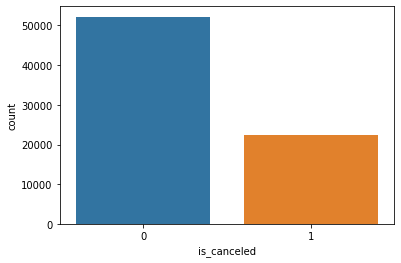

In [84]:
%matplotlib inline
print(df['is_canceled'].value_counts(normalize= True))
sns.countplot(x=df['is_canceled'])
plt.show()

In [85]:
y_train.mean()

0.3007873026508648

In [11]:
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

from sklearn.metrics import accuracy_score
print("training accuracy : ", accuracy_score(y_train, y_pred))

y_pred = [major] * len(y_val)
print("validation accuracy : ", accuracy_score(y_val, y_pred))

y_pred = [major] * len(y_test)
print("test accuracy : ", accuracy_score(y_test, y_pred))

training accuracy :  0.6992126973491353
validation accuracy :  0.6991624790619766
test accuracy :  0.6992294807370184


## Model 

In [12]:
# Encoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

# Imputer
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import make_pipeline, Pipeline

# Model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# report & score 
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, roc_curve, classification_report

# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

# eli5
import eli5
from eli5.sklearn import PermutationImportance

# warnings
import warnings

# shap 
import shap

# Logistic Rejression
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Logistic Regression


In [13]:
# Logistic Regression Randomized SearchCV

'''
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    LogisticRegression(random_state=random_state_global, n_jobs= -1)
)

dists = {    
      'targetencoder__smoothing' : [200, 225, 250, 275, 300, 325, 350, 370, 400]
    , 'targetencoder__min_samples_leaf' : randint(1, 5)
    , 'logisticregression__max_iter' : randint(1,50)
}

clf_logistic = RandomizedSearchCV(
      pipe
    , param_distributions = dists
    , n_iter = 500 
    , cv = 5
    , scoring = 'f1'
    , verbose = 1
    , n_jobs = -1
)

clf_logistic.fit(X_train, y_train)

print(clf_logistic.score(X_train, y_train))
print(clf_logistic.best_params_)

logistic_best_param = pd.DataFrame([clf_logistic.best_params_]).T
logistic_best_param
'''

"\npipe = make_pipeline(\n    TargetEncoder(),\n    SimpleImputer(),\n    LogisticRegression(random_state=random_state_global, n_jobs= -1)\n)\n\ndists = {    \n      'targetencoder__smoothing' : [200, 225, 250, 275, 300, 325, 350, 370, 400]\n    , 'targetencoder__min_samples_leaf' : randint(1, 5)\n    , 'logisticregression__max_iter' : randint(1,50)\n}\n\nclf_logistic = RandomizedSearchCV(\n      pipe\n    , param_distributions = dists\n    , n_iter = 500 \n    , cv = 5\n    , scoring = 'f1'\n    , verbose = 1\n    , n_jobs = -1\n)\n\nclf_logistic.fit(X_train, y_train)\n\nprint(clf_logistic.score(X_train, y_train))\nprint(clf_logistic.best_params_)\n\nlogistic_best_param = pd.DataFrame([clf_logistic.best_params_]).T\nlogistic_best_param\n"

In [14]:
model_logistic = make_pipeline(
    TargetEncoder(min_samples_leaf=4, smoothing= 300),
    LogisticRegression(max_iter = 48,random_state=random_state_global, n_jobs= -1)
)

model_logistic.fit(X_train, y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.


Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['hotel', 'meal', 'market_segment',
                                     'distribution_channel',
                                     'reserved_room_type', 'assigned_room_type',
                                     'deposit_type', 'customer_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=4,
                               return_df=True, smoothing=300.0, verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=48,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=7, solver='warn', tol=0.0001,
                

In [95]:
y_pred = model_logistic.predict(X_val)
logi_train_f1_score = f1_score(y_val,y_pred)
print(logi_train_f1_score)

0.5146828844483058


In [16]:
logistic_cv_score = cross_val_score(model_logistic, X_train, y_train, cv=10, scoring='f1', n_jobs= -1)
print("cross validation score : ", logistic_cv_score.mean())

cross validation score :  0.5249048501350423


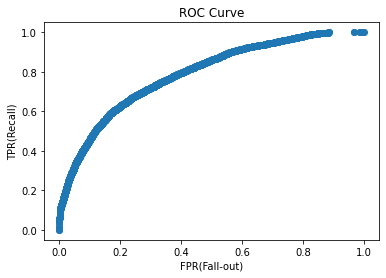

idx: 1911 , threshold : 0.35411535440342107
auc score :  0.7890803333127014


In [17]:
y_pred_proba = model_logistic.predict_proba(X_val)[:,1]

#roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)' : fpr,
    'TPRate(Recall)' : tpr,
    'Threshold' : thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold :', optimal_threshold)

y_pred_optimal = y_pred_proba >= optimal_threshold


auc_score_logistic = roc_auc_score(y_val, y_pred_proba)
print("auc score : ", auc_score_logistic)

In [18]:
y_pred_proba = model_logistic.predict_proba(X_val)[:,1]
y_test_pred_optimal = y_pred_proba >= optimal_threshold

print(classification_report(y_val, y_test_pred_optimal))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      8348
           1       0.55      0.67      0.60      3592

    accuracy                           0.73     11940
   macro avg       0.70      0.72      0.70     11940
weighted avg       0.75      0.73      0.74     11940



In [19]:
# RandomForestClassifier score

## threshold 적용
y_pred_proba = model_logistic.predict_proba(X_test)[:,1]
y_test_pred_optimal = y_pred_proba >= optimal_threshold

## f1_score
f1_score_logistic = f1_score(y_test, y_test_pred_optimal)
print("f1 score : ", f1_score_logistic)

f1 score :  0.6000000000000001


### RandomForestClassifier

In [20]:
# RandomizedSearchCV
'''
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=7, n_jobs=-1)
)

dists = {    
      'targetencoder__smoothing' : range(0,100,10)
    , 'targetencoder__min_samples_leaf' : randint(7, 12)
    , 'simpleimputer__strategy' : ['mean']
    , 'randomforestclassifier__n_estimators' : randint(50,300)
    , 'randomforestclassifier__max_depth' : randint(1,10)
    , 'randomforestclassifier__min_samples_leaf' : randint(1,10)
}

clf_rf = RandomizedSearchCV(
      pipe
    , param_distributions = dists
    , n_iter = 200
    , cv = 5
    , scoring = 'f1'
    , verbose = 1
    , n_jobs = -1
)

clf_rf.fit(X_train, y_train)
pipe = clf_rf.best_estimator_


rf_best_parm = pd.DataFrame([clf_rf.best_params_]).T
#best_parm.set_index('value_name',inplace=True)
rf_best_parm
'''

"\npipe = make_pipeline(\n    TargetEncoder(),\n    SimpleImputer(),\n    RandomForestClassifier(random_state=7, n_jobs=-1)\n)\n\ndists = {    \n      'targetencoder__smoothing' : range(0,100,10)\n    , 'targetencoder__min_samples_leaf' : randint(7, 12)\n    , 'simpleimputer__strategy' : ['mean']\n    , 'randomforestclassifier__n_estimators' : randint(50,300)\n    , 'randomforestclassifier__max_depth' : randint(1,10)\n    , 'randomforestclassifier__min_samples_leaf' : randint(1,10)\n}\n\nclf_rf = RandomizedSearchCV(\n      pipe\n    , param_distributions = dists\n    , n_iter = 200\n    , cv = 5\n    , scoring = 'f1'\n    , verbose = 1\n    , n_jobs = -1\n)\n\nclf_rf.fit(X_train, y_train)\npipe = clf_rf.best_estimator_\n\n\nrf_best_parm = pd.DataFrame([clf_rf.best_params_]).T\n#best_parm.set_index('value_name',inplace=True)\nrf_best_parm\n"

In [21]:
# rf
model_rf = make_pipeline(TargetEncoder(min_samples_leaf = 10, smoothing = 30), 
                      SimpleImputer(strategy = 'mean'),
                      RandomForestClassifier(random_state = random_state_global, 
                                             max_depth = 9, 
                                             min_samples_leaf = 1,
                                             n_estimators = 187)
)

model_rf.fit(X_train,y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['hotel', 'meal', 'market_segment',
                                     'distribution_channel',
                                     'reserved_room_type', 'assigned_room_type',
                                     'deposit_type', 'customer_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=10,
                               return_df=True, smoothing=30.0, verbose=0)),
                ('simpleimputer',
                 SimpleImpu...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=9,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_d

In [96]:
y_pred = model_rf.predict(X_val)
rf_train_f1_score = f1_score(y_val,y_pred)
print(rf_train_f1_score)

0.5445134575569358


In [22]:
rf_cv_score = cross_val_score(model_rf, X_train, y_train, cv=10, scoring='f1')
print("cross validation score : ", rf_cv_score.mean())

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future ver

cross validation score :  0.5478103985621546


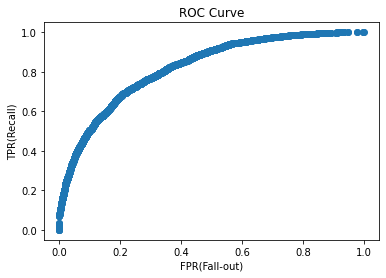

idx: 1989 , threshold : 0.33256202127123075
auc score :  0.8215229058771928


In [23]:
y_pred_proba = model_rf.predict_proba(X_val)[:,1]

#roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)' : fpr,
    'TPRate(Recall)' : tpr,
    'Threshold' : thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold :', optimal_threshold)

y_pred_optimal = y_pred_proba >= optimal_threshold


auc_score_rf = roc_auc_score(y_val, y_pred_proba)
print("auc score : ", auc_score_rf)

In [24]:
y_pred_proba = model_logistic.predict_proba(X_val)[:,1]
y_test_pred_optimal = y_pred_proba >= optimal_threshold

print(classification_report(y_val, y_test_pred_optimal))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      8348
           1       0.52      0.70      0.60      3592

    accuracy                           0.72     11940
   macro avg       0.69      0.71      0.69     11940
weighted avg       0.75      0.72      0.73     11940



In [25]:
# RandomForestClassifier score

y_pred_proba = model_rf.predict_proba(X_test)[:,1]
y_test_pred_optimal = y_pred_proba >= optimal_threshold

## f1_score
f1_score_rf = f1_score(y_test, y_test_pred_optimal)
print("f1 score : ", f1_score_rf)

f1 score :  0.6279046373604266


### XGBClassifier

In [26]:
# XGBClassifier
'''
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    XGBClassifier(
          random_state = 7
        , n_jobs = -1
        , learning_rate = 0.2
    )
)

dists = {    
      'targetencoder__smoothing' : [2, 25, 50, 100, 250, 500, 1000]
    , 'targetencoder__min_samples_leaf' : randint(1,10)
    , 'simpleimputer__strategy' : ['mean']
    , 'xgbclassifier__n_estimators' : randint(50,250)
    , 'xgbclassifier__max_depth' : randint(1,10)
}

clf_XGB = RandomizedSearchCV(
      pipe
    , param_distributions = dists
    , n_iter = 200
    , cv = 5
    , scoring = 'accuracy'
    , verbose = 1
    , n_jobs = -1
)

clf_XGB.fit(X_train, y_train)


print(clf_XGB.best_params_)

pipe = clf_XGB.best_estimator_

XGBC_best_para = pd.DataFrame([clf_XGB.best_params_]).T
XGBC_best_para
'''

"\npipe = make_pipeline(\n    TargetEncoder(),\n    SimpleImputer(),\n    XGBClassifier(\n          random_state = 7\n        , n_jobs = -1\n        , learning_rate = 0.2\n    )\n)\n\ndists = {    \n      'targetencoder__smoothing' : [2, 25, 50, 100, 250, 500, 1000]\n    , 'targetencoder__min_samples_leaf' : randint(1,10)\n    , 'simpleimputer__strategy' : ['mean']\n    , 'xgbclassifier__n_estimators' : randint(50,250)\n    , 'xgbclassifier__max_depth' : randint(1,10)\n}\n\nclf_XGB = RandomizedSearchCV(\n      pipe\n    , param_distributions = dists\n    , n_iter = 200\n    , cv = 5\n    , scoring = 'accuracy'\n    , verbose = 1\n    , n_jobs = -1\n)\n\nclf_XGB.fit(X_train, y_train)\n\n\nprint(clf_XGB.best_params_)\n\npipe = clf_XGB.best_estimator_\n\nXGBC_best_para = pd.DataFrame([clf_XGB.best_params_]).T\nXGBC_best_para\n"

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


[0]	validation_0-error:0.217995	validation_1-error:0.225544
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.217283	validation_1-error:0.227387
[2]	validation_0-error:0.216299	validation_1-error:0.225879
[3]	validation_0-error:0.216634	validation_1-error:0.225796
[4]	validation_0-error:0.215671	validation_1-error:0.225126
[5]	validation_0-error:0.216341	validation_1-error:0.225879
[6]	validation_0-error:0.215357	validation_1-error:0.225209
[7]	validation_0-error:0.215084	validation_1-error:0.224791
[8]	validation_0-error:0.214079	validation_1-error:0.223702
[9]	validation_0-error:0.213891	validation_1-error:0.223534
[10]	validation_0-error:0.212635	validation_1-error:0.221273
[11]	validation_0-error:0.212551	validation_1-error:0.220687
[12]	validation_0-error:0.210687	validation_1-error:0.220017
[13]	validation_0-error:0.211106	validation_1-error:0.21

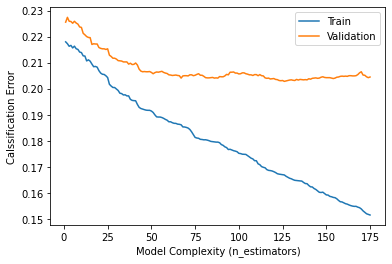

In [27]:
enc = TargetEncoder(min_samples_leaf=4, smoothing=250)

X_train_enc = enc.fit_transform(X_train,  y_train)
X_val_enc = enc.transform(X_val)
X_test_enc = enc.transform(X_test)

model = XGBClassifier(  random_state = 7
                    , n_jobs = -1
                    , learning_rate = 0.2
                    , max_depth = 7
                    , n_estimators = 500
                    )

eval_set = [(X_train_enc, y_train),
            (X_val_enc, y_val)]

model.fit(X_train_enc,y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds=50)

results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label = 'Train')
plt.plot(epoch, val_error, label = 'Validation')
plt.ylabel('Calssification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.15, 0.25))
plt.legend()
plt.show()

In [28]:
model_XGBC = make_pipeline(
    TargetEncoder(min_samples_leaf=4, smoothing= 250),
    XGBClassifier(  random_state = 7
                    , n_jobs = -1
                    , learning_rate = 0.2
                    , max_depth = 7
                    , n_estimators = 124
                    ))

model_XGBC.fit(X_train,y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['hotel', 'meal', 'market_segment',
                                     'distribution_channel',
                                     'reserved_room_type', 'assigned_room_type',
                                     'deposit_type', 'customer_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=4,
                               return_df=True, smoothing=250.0, verbose=0)),
                ('xgbclassifier',
                 XGBClassif...oster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.2,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=None,
                               n_estimators=124, n_jobs=-1, nthread=None

In [97]:
y_pred = model_XGBC.predict(X_val)
XGBC_train_f1_score = f1_score(y_val,y_pred)
print(XGBC_train_f1_score)

0.6205601627288373


In [29]:
xgbc_cv_score = cross_val_score(model_XGBC, X_train, y_train, cv=10, scoring='f1')
print("cross validation score : ", xgbc_cv_score.mean())

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future ver

cross validation score :  0.624205949226526


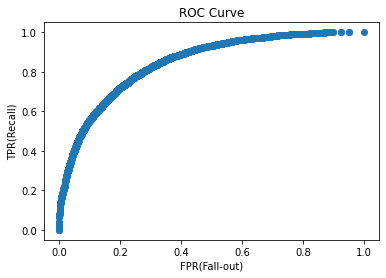

idx: 2132 , threshold : 0.29873422
auc score :  0.8467267375565998


In [30]:
y_pred_proba = model_XGBC.predict_proba(X_val)[:,1]

#roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)' : fpr,
    'TPRate(Recall)' : tpr,
    'Threshold' : thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold :', optimal_threshold)

y_pred_optimal = y_pred_proba >= optimal_threshold


auc_score_XGBC = roc_auc_score(y_val, y_pred_proba)
print("auc score : ", auc_score_XGBC)

In [31]:
y_pred_proba = model_logistic.predict_proba(X_val)[:,1]
y_test_pred_optimal = y_pred_proba >= optimal_threshold

print(classification_report(y_val, y_test_pred_optimal))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      8348
           1       0.49      0.75      0.59      3592

    accuracy                           0.69     11940
   macro avg       0.67      0.71      0.67     11940
weighted avg       0.75      0.69      0.70     11940



In [32]:
# XGBClassifier score

y_pred_proba = model_XGBC.predict_proba(X_test)[:,1]
y_test_pred_optimal = y_pred_proba >= optimal_threshold

## f1_score
f1_score_XBGC = f1_score(y_test, y_test_pred_optimal)
print("f1 score : ", f1_score_XBGC)

f1 score :  0.6569427118318779


## model compare

In [99]:
# test data 기준 f1_score 비교
model_compare = pd.DataFrame([['LogisticRegreeion', logi_train_f1_score, logistic_cv_score.mean(),f1_score_logistic ],
                              ['RandomForestClassifier',rf_train_f1_score, rf_cv_score.mean(), f1_score_rf],
                              ['XGBClassifier', XGBC_train_f1_score, xgbc_cv_score.mean(), f1_score_XBGC]])

model_compare.columns = ['Model','train_f1_score', 'Cross_validaion_score','test_f1_score']

model_compare.set_index('Model', inplace = True)

model_compare = model_compare.sort_values('test_f1_score', ascending=False)

model_compare

,train_f1_score,Cross_validaion_score,test_f1_score
Model,,,
XGBClassifier,0.620560,0.624206,0.656943
RandomForestClassifier,0.544513,0.547810,0.627905
LogisticRegreeion,0.514683,0.524905,0.600000


In [107]:
model_compare.iloc[0]

train_f1_score           0.620560
Cross_validaion_score    0.624206
test_f1_score            0.656943
Name: XGBClassifier, dtype: float64

# Model Visualized

## set data ( best para )

In [34]:
enc = TargetEncoder(min_samples_leaf=4, smoothing= 250)

X_train_enc = enc.fit_transform(X_train,y_train)
X_test_enc = enc.transform(X_test)

best_model = XGBClassifier(  
    random_state = 7
    , n_jobs = -1
    , learning_rate = 0.2
    , max_depth = 7
    , n_estimators = 124
    )

best_model.fit(X_train_enc, y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=124, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
warnings.simplefilter(action = 'ignore', category = FutureWarning)

permuter = PermutationImportance(
    best_model,
    scoring = 'f1',
    n_iter = 5,
    random_state=7
)

permuter.fit(X_train_enc,y_train)

feature_names = X_train.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1863 ± 0.0027,assigned_room_type
0.1855 ± 0.0037,reserved_room_type
0.1169 ± 0.0045,total_of_special_requests
0.1150 ± 0.0018,lead_time
0.0871 ± 0.0032,market_segment
0.0714 ± 0.0015,adr
0.0538 ± 0.0015,customer_type
0.0398 ± 0.0027,required_car_parking_spaces
0.0339 ± 0.0021,booking_changes
0.0282 ± 0.0014,fare_per_day


In [114]:
num = 41
pd.DataFrame(X_test_enc.iloc[[num]])

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,stay_in_all_days,fare_per_day
43170,0.320382,262,2,2,2,0.0,0,0.365173,0.356931,0.31393,0,0,0,0.288592,0.331825,0,0.293107,0,0.331045,89.1,0,0,4,22.275


In [115]:
# shap feature value : 1 feature
row = X_test_enc.iloc[[num]]
model = best_model

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
  
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row
)

In [104]:
# shap features values
shap_values = explainer.shap_values(X_test_enc.iloc[:300])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test_enc.iloc[:301])

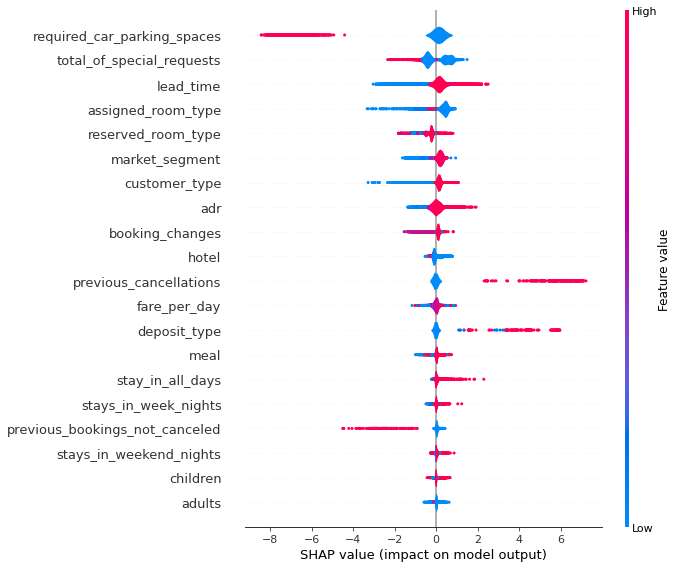

In [50]:
shap_values = explainer.shap_values(X_test_enc)
shap.summary_plot(shap_values, X_test_enc, plot_type="violin")

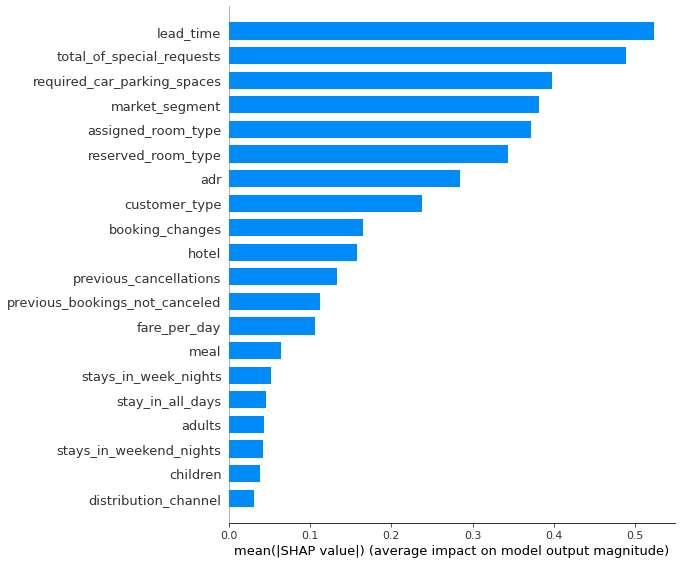

In [47]:
shap.summary_plot(shap_values, X_test_enc, plot_type="bar")